# **NT522.P21.ANTT - Lab 5**

# **Phát hiện bất thường mạng sử dụng mô hình GRU**
Trong bài thực hành này, ta sẽ tạo và huấn luyện mô hình GRU để phát hiện xâm nhập mạng.


In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
#Bước 2
import os
os.chdir('/content/drive/MyDrive/Colab-Notebooks/')

In [3]:
!pwd
!ls

/content/drive/MyDrive/Colab-Notebooks
cic-iot-2023  fist.ipynb  Untitled


# **A. Hướng dẫn xây dựng mô hình phân loại 2 lớp**





## **1. Đọc tập dữ liệu KDD99**

In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

from tensorflow.keras.utils import get_file
try:
    path = get_file('kddcup.data_10_percent.gz', origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading')
    raise

print(path)

2144903/2144903 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step
/root/.keras/datasets/kddcup.data_10_percent.gz


In [7]:
df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

Read 494021 rows.


In [8]:
# CSV không có header
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
              'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
              'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
              'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
              'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
              'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


## **2. Xử lý dữ liệu**

In [9]:
df.shape

(494021, 42)

In [10]:
df.dropna(inplace=True,axis=1)
df.shape

(494021, 42)

In [11]:
df.dtypes

,0
duration,int64
protocol_type,object
service,object
flag,object
src_bytes,int64
dst_bytes,int64
land,int64
wrong_fragment,int64
urgent,int64
hot,int64


In [12]:
df.groupby('outcome')['outcome'].count()

,outcome
outcome,
back.,2203
buffer_overflow.,30
ftp_write.,8
guess_passwd.,53
imap.,12
ipsweep.,1247
land.,21
loadmodule.,9
multihop.,7


## **3. Encode dữ liệu số và chữ**

In [13]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

In [14]:
#encoding feature vector
text_col =['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', ]

for i in df.columns:
  if i not in text_col:
    if i != 'outcome':
      encode_numeric_zscore(df, i)

for x in text_col:
  encode_text_dummy(df, x)

<ipython-input-13-0ff5670ea7e1>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-13-0ff5670ea7e1>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
<ipython-input-13-0ff5670ea7e1>:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
 

In [15]:
df.dropna(inplace=True,axis=1)
df[0:5]

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.067792,-0.002879,0.138664,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
1,-0.067792,-0.002820,-0.011578,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
2,-0.067792,-0.002824,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
3,-0.067792,-0.002840,0.014179,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False
4,-0.067792,-0.002842,0.035214,-0.04772,-0.002571,-0.044136,-0.009782,-0.005679,-0.010552,-0.004676,...,False,True,False,True,False,False,True,True,True,False


In [16]:
df['protocol_type-tcp'].unique()

array([ True, False])

In [17]:
df.loc[df["outcome"] != "normal.", "outcome"] = 1
df.loc[df["outcome"] == "normal.", "outcome"] = 0

In [18]:
y = df['outcome']
df.drop('outcome',axis=1,inplace=True)

In [19]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df, y,  test_size=0.3, random_state=12)

print(f"Normal train count: {x_train.shape, y_train.shape}")
print(f"Normal test count: {x_test.shape, y_test.shape}")

Normal train count: ((345814, 120), (345814,))
Normal test count: ((148207, 120), (148207,))


In [20]:
y_train = tf.one_hot(y_train.values, 2)
y_test = tf.one_hot(y_test.values, 2)

## **4. Kiến trúc mô hình GRU**

In [21]:
model = keras.Sequential()
model.add(keras.layers.GRU(units=64, input_shape=(x_train.shape[1],1)))
model.add(keras.layers.Dropout(rate=0.8))
model.add(keras.layers.Dense(units=y_train.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,994 (50.76 KB)

 Trainable params: 12,994 (50.76 KB)

 Non-trainable params: 0 (0.00 B)

## **5. Huấn luyện mô hình**

In [22]:
history = model.fit(
    x_train, y_train,
    epochs=2,
    batch_size=1024,
    validation_split=0.2,
    shuffle = False
)

Epoch 1/2
271/271 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7821 - loss: 0.5541 - val_accuracy: 0.8031 - val_loss: 0.8020
Epoch 2/2
271/271 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.8809 - loss: 0.3496 - val_accuracy: 0.9776 - val_loss: 0.0854


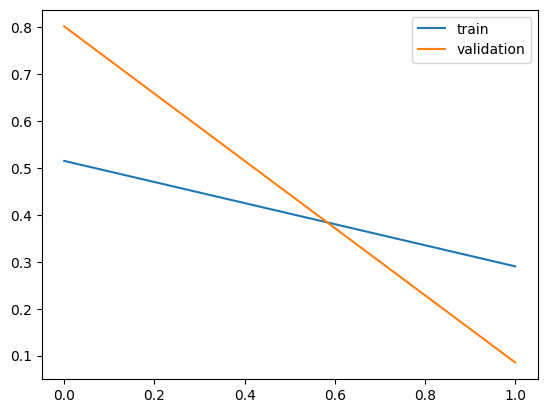

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

## **6. Đánh giá mô hình**

In [24]:
score1 = model.evaluate(x_train, y_train, batch_size=1024)

338/338 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9771 - loss: 0.0853


# **B. Bài tập**


1.   **Yêu cầu 1 (Tại lớp): Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99.**
2.   **Yêu cầu 2 (Về nhà): Sinh viên chạy lại tập dữ liệu [CIC IoT dataset 2023](https://www.unb.ca/cic/datasets/iotdataset-2023.html) trên mô hình bài lab này ở cả Multiclass Classification và Binary Classification.**





In [ ]:
# Import necessary libraries
import glob
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import get_file

## **Yêu Cầu 1: Dựa trên hướng dẫn A hãy xây dựng một mô hình phân loại đa lớp (Multiclass Classification) với bộ dữ liệu KDD99**

### **1. Đọc tập dữ liệu KDD99**

In [ ]:
try:
    path = get_file('kddcup.data_10_percent.gz',
                    origin='http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz')
except:
    print('Error downloading KDD99 dataset')
    raise

print(path)

df = pd.read_csv(path, header=None)
print("Read {} rows.".format(len(df)))

/Users/tranthehuuphuc/.keras/datasets/kddcup.data_10_percent.gz
Read 494021 rows.


In [ ]:
# Đặt tên cột
df.columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
                'num_failed_logins','logged_in','num_compromised','root_shell', 'su_attempted','num_root','num_file_creations','num_shells',
                'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
                'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
                'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate',
                'dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome']

df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


### **2. Xử lý dữ liệu**

In [ ]:
df.shape

(494021, 42)

In [ ]:
df.dropna(inplace=True, axis=1)
df.shape

(494021, 42)

In [ ]:
df.dtypes

duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [ ]:
df.groupby('outcome')['outcome'].count()

outcome
back.                 2203
buffer_overflow.        30
ftp_write.               8
guess_passwd.           53
imap.                   12
ipsweep.              1247
land.                   21
loadmodule.              9
multihop.                7
neptune.            107201
nmap.                  231
normal.              97278
perl.                    3
phf.                     4
pod.                   264
portsweep.            1040
rootkit.                10
satan.                1589
smurf.              280790
spy.                     2
teardrop.              979
warezclient.          1020
warezmaster.            20
Name: outcome, dtype: int64

In [ ]:
attack_mapping = {
    'normal.': 'normal',
    'back.': 'dos', 'land.': 'dos', 'neptune.': 'dos', 'pod.': 'dos', 'smurf.': 'dos', 'teardrop.': 'dos',
    'ipsweep.': 'probe', 'nmap.': 'probe', 'portsweep.': 'probe', 'satan.': 'probe',
    'ftp_write.': 'r2l', 'guess_passwd.': 'r2l', 'imap.': 'r2l', 'multihop.': 'r2l', 'phf.': 'r2l', 'spy.': 'r2l', 'warezclient.': 'r2l', 'warezmaster.': 'r2l',
    'buffer_overflow.': 'u2r', 'loadmodule.': 'u2r', 'perl.': 'u2r', 'rootkit.': 'u2r'
}

df['attack_category'] = df['outcome'].map(attack_mapping)
df['attack_category'] = df['attack_category'].fillna('other')

print(df['attack_category'].value_counts())

attack_category
dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: count, dtype: int64


### **3. Encode dữ liệu số và chữ**

In [ ]:
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()
    if sd is None:
        sd = df[name].std()
    df[name] = (df[name] - mean) / sd

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encoding feature vector
text_col = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']

# Normalize numeric features
for col in df.columns:
    if col not in text_col and col not in ['outcome', 'attack_category']:
        encode_numeric_zscore(df, col)

# Encode text features
for col in text_col:
    encode_text_dummy(df, col)

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['attack_category'])

# Loại bỏ cột không cần thiết
df.drop(['outcome', 'attack_category'], axis=1, inplace=True)
df.dropna(inplace=True, axis=1)

/var/folders/m_/c8s5m70j7gxd8zgn3kpn9fsr0000gn/T/ipykernel_7555/990497203.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
/var/folders/m_/c8s5m70j7gxd8zgn3kpn9fsr0000gn/T/ipykernel_7555/990497203.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[dummy_name] = dummies[x]
/var/folders/m_/c8s5m70j7gxd8zgn3kpn9fsr0000gn/T/ipykernel_7555/990497203.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performanc

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"Train set: {X_train.shape}, Test set: {X_test.shape}")

Train set: (345814, 120), Test set: (148207, 120)


### **4. Kiến trúc mô hình GRU**

In [ ]:
def build_gru_multiclass_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        keras.layers.GRU(units=128, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.GRU(units=64),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=num_classes, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

model = build_gru_multiclass_model(X_train.shape[1], len(label_encoder.classes_))
print("\nKiến trúc mô hình:")
model.summary()


Kiến trúc mô hình:


/Users/tranthehuuphuc/Desktop/.venv/lib/python3.9/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 120, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 120, 128)       │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,797 (350.77 KB)

 Trainable params: 89,797 (350.77 KB)

 Non-trainable params: 0 (0.00 B)

### **5. Huấn luyện mô hình**

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=1024,
    validation_split=0.2,
    verbose=1
)

Epoch 1/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 264s 970ms/step - accuracy: 0.7391 - loss: 0.8746 - val_accuracy: 0.7920 - val_loss: 0.3532
Epoch 2/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.7873 - loss: 0.5657 - val_accuracy: 0.7924 - val_loss: 0.5598
Epoch 3/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 257s 949ms/step - accuracy: 0.7927 - loss: 0.5747 - val_accuracy: 0.7924 - val_loss: 0.5475
Epoch 4/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 251s 924ms/step - accuracy: 0.8260 - loss: 0.5434 - val_accuracy: 0.9753 - val_loss: 0.0923
Epoch 5/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 255s 942ms/step - accuracy: 0.9434 - loss: 0.1889 - val_accuracy: 0.8034 - val_loss: 0.4993
Epoch 6/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 264s 972ms/step - accuracy: 0.8659 - loss: 0.3830 - val_accuracy: 0.9824 - val_loss: 0.0603
Epoch 7/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 258s 952ms/step - accuracy: 0.9824 - loss: 0.0739 - val_accuracy: 0.9875 - val_loss: 0.0500
Epoch 8/10
271/271 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.9857 - loss:

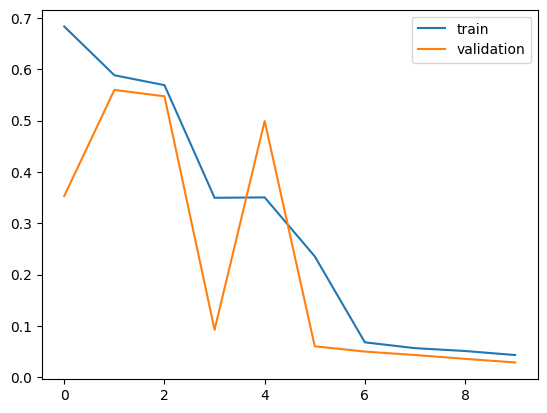

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()

### **6. Đánh giá mô hình**

In [ ]:
score1 = model.evaluate(X_train, y_train, batch_size=1024)

print("\nĐánh giá trên tập test:")
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

print("\nBáo cáo phân loại:")
y_pred = model.predict(X_test, verbose=0)
y_pred_classes = np.argmax(y_pred, axis=1)
print(metrics.classification_report(y_test, y_pred_classes,
                                    target_names=label_encoder.classes_))

338/338 ━━━━━━━━━━━━━━━━━━━━ 102s 302ms/step - accuracy: 0.9939 - loss: 0.0290

Đánh giá trên tập test:
Test Accuracy: 0.9939
Test Loss: 0.0297

Báo cáo phân loại:
              precision    recall  f1-score   support

         dos       1.00      1.00      1.00    117438
      normal       0.98      0.99      0.99     29183
       probe       0.86      0.89      0.88      1232
         r2l       0.00      0.00      0.00       338
         u2r       0.00      0.00      0.00        16

    accuracy                           0.99    148207
   macro avg       0.57      0.58      0.57    148207
weighted avg       0.99      0.99      0.99    148207



/Users/tranthehuuphuc/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tranthehuuphuc/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tranthehuuphuc/Desktop/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

## **Yêu Cầu 2: Sinh viên chạy lại tập dữ liệu [CIC IoT dataset 2023](https://www.unb.ca/cic/datasets/iotdataset-2023.html) trên mô hình bài lab này ở cả Multiclass Classification và Binary Classification**

### **A. Binary Classification cho CIC IoT Dataset 2023**


Note: Nhóm sử dụng 4 file .csv ~ 500MB của CIC IoT dataset 2023 để thực hiện phần A và B.

#### **1. Đọc và xử lý dữ liệu CIC IoT 2023**


In [ ]:
# Tạo thư mục
!mkdir -p cic-iot-2023

# Tải từng file vào thư mục bằng cách chỉ định đường dẫn đích
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged01.csv
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged02.csv
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged03.csv
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged04.csv
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged05.csv
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged06.csv
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged07.csv
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged08.csv
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged09.csv
!wget -P cic-iot-2023 http://cicresearch.ca/IOTDataset/CIC_IOT_Dataset2023/Dataset/CSV/MERGED_CSV/Merged10.csv


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import glob
import os


In [16]:

# Đọc tất cả file CSV từ thư mục cic-iot-2023
folder_path = "./cic-iot-2023/"

if not os.path.exists(folder_path):
    print(f"Folder {folder_path} does not exist.")
    raise FileNotFoundError(f"Folder {folder_path} does not exist.")

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
print(f"Found {len(csv_files)} CSV files.")

dfs = []
for file in csv_files:
    try:
        df_temp = pd.read_csv(file, low_memory=False)

        if 'Unnamed: 0' in df_temp.columns:
            df_temp.drop('Unnamed: 0', axis=1, inplace=True)

        df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_temp.dropna(inplace=True)

        dfs.append(df_temp)
        print(f"Successfully processed: {file} (shape: {df_temp.shape})")
    except Exception as e:
        print(f"Error processing {file}: {e}")

if dfs:
    df_cic = pd.concat(dfs, ignore_index=True)
    print(f"\nCombined DataFrame shape: {df_cic.shape}")

    df_cic.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_cic.dropna(inplace=True)

    print(f"Final DataFrame shape after cleaning: {df_cic.shape}")
    print("\nDataset info:")
    print(df_cic.head())
    print("\nLabel distribution:")
    print(df_cic['Label'].value_counts())
else:
    raise ValueError("No valid CSV files found in the specified folder.")


Found 4 CSV files.
Successfully processed: ./cic-iot-2023/Merged01.csv (shape: (712297, 40))
Successfully processed: ./cic-iot-2023/Merged02.csv (shape: (748572, 40))
Successfully processed: ./cic-iot-2023/Merged03.csv (shape: (697272, 40))
Successfully processed: ./cic-iot-2023/Merged04.csv (shape: (676597, 40))

Combined DataFrame shape: (2834738, 40)
Final DataFrame shape after cleaning: (2834738, 40)

Dataset info:
   Header_Length  Protocol Type  Time_To_Live          Rate  fin_flag_number  \
0          19.92              6         63.36  25893.962218              0.0   
1           0.00             47         64.00   3703.841331              0.0   
2           7.92             17         65.91  19673.095685              0.0   
3          20.40              6        110.50    261.664826              0.1   
4           0.32              1         63.96  28944.199848              0.0   

   syn_flag_number  rst_flag_number  psh_flag_number  ack_flag_number  \
0              0.0     


#### **2. Chuẩn bị dữ liệu cho Binary Classification**


In [17]:
# Tách features và labels
X_cic = df_cic.drop('Label', axis=1)
y_cic = df_cic['Label']

# Chỉ giữ lại các cột số
numeric_cols = X_cic.select_dtypes(include=[np.number]).columns
X_cic = X_cic[numeric_cols]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_cic_scaled = scaler.fit_transform(X_cic)
X_cic_scaled = pd.DataFrame(X_cic_scaled, columns=X_cic.columns)

# Tạo binary labels (Normal vs Attack)
y_binary = (y_cic != 'Normal').astype(int)

print(f"Features shape: {X_cic_scaled.shape}")
print(f"Binary labels distribution:\n{y_binary.value_counts()}")


Features shape: (2834738, 39)
Binary labels distribution:
Label
1    2834738
Name: count, dtype: int64



#### **3. Chia tập train/test**


In [18]:
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_cic_scaled, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

print(f"Train set: {X_train_bin.shape}, Test set: {X_test_bin.shape}")


Train set: (1984316, 39), Test set: (850422, 39)



#### **4. Xây dựng mô hình GRU cho Binary Classification**


In [19]:
def build_gru_binary_model(input_shape):
    model = keras.Sequential([
        keras.layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        keras.layers.GRU(units=64, return_sequences=False),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=1, activation='sigmoid')
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

model_binary = build_gru_binary_model(X_train_bin.shape[1])
print("Binary Classification Model Architecture:")
model_binary.summary()


Binary Classification Model Architecture:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)             │ (None, 39, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,977 (58.50 KB)

 Non-trainable params: 0 (0.00 B)


#### **5. Huấn luyện mô hình Binary**


In [20]:
print("Training Binary Classification model...")
history_binary = model_binary.fit(
    X_train_bin, y_train_bin,
    epochs=10,
    batch_size=1024,
    validation_split=0.2,
    verbose=1
)


Training Binary Classification model...
Epoch 1/10
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9967 - loss: 0.0500 - val_accuracy: 1.0000 - val_loss: 6.1523e-09
Epoch 2/10
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 1.0000 - loss: 3.9616e-06 - val_accuracy: 1.0000 - val_loss: 5.3380e-10
Epoch 3/10
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 1.0000 - loss: 1.1076e-06 - val_accuracy: 1.0000 - val_loss: 6.0305e-11
Epoch 4/10
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 1.0000 - loss: 4.1096e-07 - val_accuracy: 1.0000 - val_loss: 1.0877e-11
Epoch 5/10
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 1.0000 - loss: 2.0979e-07 - val_accuracy: 1.0000 - val_loss: 1.9203e-12
Epoch 6/10
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 1.0000 - loss: 1.4225e-07 - val_accuracy: 1.0000 - val_loss: 3.4347e-13
Epoch 7/10
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - accuracy: 1.0000 - loss: 3.7380e-08 - val_accuracy: 1.0000 - val_l


#### **6. Vẽ biểu đồ loss**


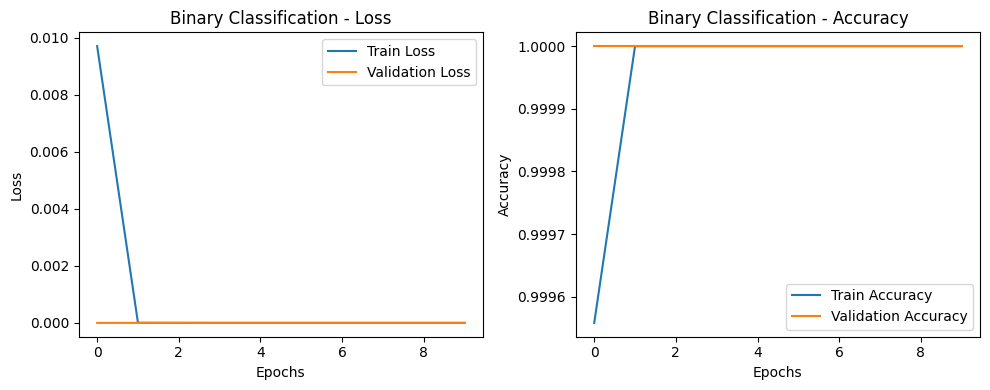

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_binary.history['loss'], label='Train Loss')
plt.plot(history_binary.history['val_loss'], label='Validation Loss')
plt.title('Binary Classification - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_binary.history['accuracy'], label='Train Accuracy')
plt.plot(history_binary.history['val_accuracy'], label='Validation Accuracy')
plt.title('Binary Classification - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()



#### **7. Đánh giá mô hình Binary**


In [22]:
print("\n=== BINARY CLASSIFICATION RESULTS ===")
test_loss, test_acc = model_binary.evaluate(X_test_bin, y_test_bin, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Dự đoán và tính metrics
y_pred_binary = model_binary.predict(X_test_bin, verbose=0)
y_pred_binary_classes = (y_pred_binary > 0.5).astype(int).flatten()

# Kiểm tra số lượng class duy nhất trong predictions
unique_classes = np.unique(y_pred_binary_classes)
print(f"Unique predicted classes: {unique_classes}")
print(f"Unique actual classes: {np.unique(y_test_bin)}")

print("\nClassification Report:")
try:
    # Chỉ sử dụng target_names nếu có đủ 2 class trong predictions
    if len(unique_classes) >= 2:
        print(metrics.classification_report(y_test_bin, y_pred_binary_classes,
                                            target_names=['Normal', 'Attack']))
    else:
        # Không sử dụng target_names nếu chỉ có 1 class
        print(metrics.classification_report(y_test_bin, y_pred_binary_classes))
        print("\nNote: Model chỉ dự đoán 1 class duy nhất. Có thể cần điều chỉnh threshold hoặc model.")
except Exception as e:
    print(f"Error in classification report: {e}")
    print("Fallback classification report:")
    print(metrics.classification_report(y_test_bin, y_pred_binary_classes))

print("\nConfusion Matrix:")
print(metrics.confusion_matrix(y_test_bin, y_pred_binary_classes))

# Thêm thống kê chi tiết
print(f"\nDetailed Statistics:")
print(f"Accuracy: {metrics.accuracy_score(y_test_bin, y_pred_binary_classes):.4f}")
print(f"Precision: {metrics.precision_score(y_test_bin, y_pred_binary_classes, average='weighted', zero_division=0):.4f}")
print(f"Recall: {metrics.recall_score(y_test_bin, y_pred_binary_classes, average='weighted', zero_division=0):.4f}")
print(f"F1-score: {metrics.f1_score(y_test_bin, y_pred_binary_classes, average='weighted', zero_division=0):.4f}")

# Kiểm tra phân phối dự đoán
print(f"\nPrediction distribution:")
print(f"Normal (0): {np.sum(y_pred_binary_classes == 0)}")
print(f"Attack (1): {np.sum(y_pred_binary_classes == 1)}")
print(f"Actual distribution:")
print(f"Normal (0): {np.sum(y_test_bin == 0)}")
print(f"Attack (1): {np.sum(y_test_bin == 1)}")

# Thử với threshold khác nhau
print("\nTrying different thresholds:")
for threshold in [0.3, 0.4, 0.5, 0.6, 0.7]:
    y_pred_thresh = (y_pred_binary > threshold).astype(int).flatten()
    unique_pred = np.unique(y_pred_thresh)
    acc = metrics.accuracy_score(y_test_bin, y_pred_thresh)
    print(f"Threshold {threshold}: Accuracy = {acc:.4f}, Unique predictions = {unique_pred}")


=== BINARY CLASSIFICATION RESULTS ===
Test Accuracy: 1.0000
Test Loss: 0.0000
Unique predicted classes: [1]
Unique actual classes: [1]

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00    850422

    accuracy                           1.00    850422
   macro avg       1.00      1.00      1.00    850422
weighted avg       1.00      1.00      1.00    850422


Note: Model chỉ dự đoán 1 class duy nhất. Có thể cần điều chỉnh threshold hoặc model.

Confusion Matrix:
[[850422]]

Detailed Statistics:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000

Prediction distribution:
Normal (0): 0
Attack (1): 850422
Actual distribution:
Normal (0): 0
Attack (1): 850422

Trying different thresholds:
Threshold 0.3: Accuracy = 1.0000, Unique predictions = [1]
Threshold 0.4: Accuracy = 1.0000, Unique predictions = [1]
Threshold 0.5: Accuracy = 1.0000, Unique predictions = [1]
Threshold 0.6: Accuracy = 1.0000, Unique 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


### **B. Multiclass Classification cho CIC IoT Dataset 2023**


Note: Nhóm xin giảm xuống còn 4 file file .csv của CIC IoT dataset 2023 để thực hiện phần B. Vì với 10 file thì model này train rất lâu, máy gánh không nổi ạ.

#### **1. Chuẩn bị dữ liệu cho Multiclass Classification**

In [6]:

# Đọc tất cả file CSV từ thư mục cic-iot-2023
folder_path = "./cic-iot-2023/"

if not os.path.exists(folder_path):
    print(f"Folder {folder_path} does not exist.")
    raise FileNotFoundError(f"Folder {folder_path} does not exist.")

csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
print(f"Found {len(csv_files)} CSV files.")

dfs = []
for file in csv_files:
    try:
        df_temp = pd.read_csv(file, low_memory=False)

        if 'Unnamed: 0' in df_temp.columns:
            df_temp.drop('Unnamed: 0', axis=1, inplace=True)

        df_temp.replace([np.inf, -np.inf], np.nan, inplace=True)
        df_temp.dropna(inplace=True)

        dfs.append(df_temp)
        print(f"Successfully processed: {file} (shape: {df_temp.shape})")
    except Exception as e:
        print(f"Error processing {file}: {e}")

if dfs:
    df_cic = pd.concat(dfs, ignore_index=True)
    print(f"\nCombined DataFrame shape: {df_cic.shape}")

    df_cic.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_cic.dropna(inplace=True)

    print(f"Final DataFrame shape after cleaning: {df_cic.shape}")
    print("\nDataset info:")
    print(df_cic.head())
    print("\nLabel distribution:")
    print(df_cic['Label'].value_counts())
else:
    raise ValueError("No valid CSV files found in the specified folder.")


Found 4 CSV files.
Successfully processed: ./cic-iot-2023/Merged01.csv (shape: (712297, 40))
Successfully processed: ./cic-iot-2023/Merged02.csv (shape: (748572, 40))
Successfully processed: ./cic-iot-2023/Merged03.csv (shape: (697272, 40))
Successfully processed: ./cic-iot-2023/Merged04.csv (shape: (676597, 40))

Combined DataFrame shape: (2834738, 40)
Final DataFrame shape after cleaning: (2834738, 40)

Dataset info:
   Header_Length  Protocol Type  Time_To_Live          Rate  fin_flag_number  \
0          19.92              6         63.36  25893.962218              0.0   
1           0.00             47         64.00   3703.841331              0.0   
2           7.92             17         65.91  19673.095685              0.0   
3          20.40              6        110.50    261.664826              0.1   
4           0.32              1         63.96  28944.199848              0.0   

   syn_flag_number  rst_flag_number  psh_flag_number  ack_flag_number  \
0              0.0     

In [7]:
# Tách features và labels
X_cic = df_cic.drop('Label', axis=1)
y_cic = df_cic['Label']

# Chỉ giữ lại các cột số
numeric_cols = X_cic.select_dtypes(include=[np.number]).columns
X_cic = X_cic[numeric_cols]

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_cic_scaled = scaler.fit_transform(X_cic)
X_cic_scaled = pd.DataFrame(X_cic_scaled, columns=X_cic.columns)

# Tạo binary labels (Normal vs Attack)
y_binary = (y_cic != 'Normal').astype(int)

print(f"Features shape: {X_cic_scaled.shape}")
print(f"Binary labels distribution:\n{y_binary.value_counts()}")

Features shape: (2834738, 39)
Binary labels distribution:
Label
1    2834738
Name: count, dtype: int64


In [8]:
# Sử dụng lại X_cic_scaled từ phần trước
X_multi = X_cic_scaled.copy()
y_multi = y_cic.copy()

# Encode labels cho multiclass
label_encoder = LabelEncoder()
y_multi_encoded = label_encoder.fit_transform(y_multi)

print(f"Number of classes: {len(label_encoder.classes_)}")
print(f"Classes: {label_encoder.classes_}")
print(f"\nClass distribution:")
for i, class_name in enumerate(label_encoder.classes_):
    count = sum(y_multi_encoded == i)
    print(f"{class_name}: {count}")


Number of classes: 34
Classes: ['BACKDOOR_MALWARE' 'BENIGN' 'BROWSERHIJACKING' 'COMMANDINJECTION'
 'DDOS-ACK_FRAGMENTATION' 'DDOS-HTTP_FLOOD' 'DDOS-ICMP_FLOOD'
 'DDOS-ICMP_FRAGMENTATION' 'DDOS-PSHACK_FLOOD' 'DDOS-RSTFINFLOOD'
 'DDOS-SLOWLORIS' 'DDOS-SYNONYMOUSIP_FLOOD' 'DDOS-SYN_FLOOD'
 'DDOS-TCP_FLOOD' 'DDOS-UDP_FLOOD' 'DDOS-UDP_FRAGMENTATION'
 'DICTIONARYBRUTEFORCE' 'DNS_SPOOFING' 'DOS-HTTP_FLOOD' 'DOS-SYN_FLOOD'
 'DOS-TCP_FLOOD' 'DOS-UDP_FLOOD' 'MIRAI-GREETH_FLOOD' 'MIRAI-GREIP_FLOOD'
 'MIRAI-UDPPLAIN' 'MITM-ARPSPOOFING' 'RECON-HOSTDISCOVERY' 'RECON-OSSCAN'
 'RECON-PINGSWEEP' 'RECON-PORTSCAN' 'SQLINJECTION' 'UPLOADING_ATTACK'
 'VULNERABILITYSCAN' 'XSS']

Class distribution:
BACKDOOR_MALWARE: 180
BENIGN: 66392
BROWSERHIJACKING: 344
COMMANDINJECTION: 313
DDOS-ACK_FRAGMENTATION: 17328
DDOS-HTTP_FLOOD: 1766
DDOS-ICMP_FLOOD: 432861
DDOS-ICMP_FRAGMENTATION: 27244
DDOS-PSHACK_FLOOD: 247293
DDOS-RSTFINFLOOD: 244021
DDOS-SLOWLORIS: 1380
DDOS-SYNONYMOUSIP_FLOOD: 217406
DDOS-SYN_FLOOD: 245602



#### **2. Chia tập train/test cho Multiclass**


In [9]:
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi, y_multi_encoded, test_size=0.3, random_state=42, stratify=y_multi_encoded
)

print(f"Train set: {X_train_multi.shape}, Test set: {X_test_multi.shape}")


Train set: (1984316, 39), Test set: (850422, 39)



#### **3. Xây dựng mô hình GRU cho Multiclass Classification**


In [10]:
def build_gru_multiclass_model(input_shape, num_classes):
    model = keras.Sequential([
        keras.layers.Reshape((input_shape, 1), input_shape=(input_shape,)),
        keras.layers.GRU(units=128, return_sequences=True),
        keras.layers.Dropout(0.3),
        keras.layers.GRU(units=64, return_sequences=False),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(units=32, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(units=num_classes, activation='softmax')
    ])

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    return model

model_multiclass = build_gru_multiclass_model(X_train_multi.shape[1], len(label_encoder.classes_))
print("\nMulticlass Classification Model Architecture:")
model_multiclass.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Multiclass Classification Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 39, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 39, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 34)             │         1,122 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,754 (354.51 KB)

 Trainable params: 90,754 (354.51 KB)

 Non-trainable params: 0 (0.00 B)


#### **4. Huấn luyện mô hình Multiclass**


In [11]:
print("Training Multiclass Classification model...")
history_multiclass = model_multiclass.fit(
    X_train_multi, y_train_multi,
    epochs=15,
    batch_size=1024,
    validation_split=0.2,
    verbose=1
)


Training Multiclass Classification model...
Epoch 1/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.5530 - loss: 1.2517 - val_accuracy: 0.7266 - val_loss: 0.5398
Epoch 2/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.7195 - loss: 0.5624 - val_accuracy: 0.7305 - val_loss: 0.5157
Epoch 3/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.7251 - loss: 0.5385 - val_accuracy: 0.7335 - val_loss: 0.5073
Epoch 4/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 39s 23ms/step - accuracy: 0.7306 - loss: 0.5261 - val_accuracy: 0.7420 - val_loss: 0.4940
Epoch 5/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 43s 24ms/step - accuracy: 0.7352 - loss: 0.5139 - val_accuracy: 0.7434 - val_loss: 0.4880
Epoch 6/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.7367 - loss: 0.5087 - val_accuracy: 0.7446 - val_loss: 0.4861
Epoch 7/15
1551/1551 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.7395 - loss: 0.5026 - val_accuracy: 0.7443 - val_loss: 0.4836
Epoch 8/15
1551/1551 ━━━━━━━━━━━


#### **5. Vẽ biểu đồ loss cho Multiclass**


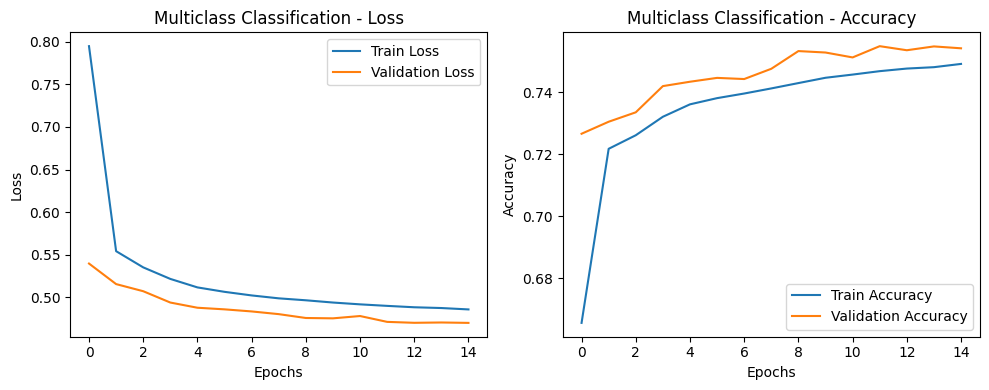

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_multiclass.history['loss'], label='Train Loss')
plt.plot(history_multiclass.history['val_loss'], label='Validation Loss')
plt.title('Multiclass Classification - Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_multiclass.history['accuracy'], label='Train Accuracy')
plt.plot(history_multiclass.history['val_accuracy'], label='Validation Accuracy')
plt.title('Multiclass Classification - Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()



#### **6. Đánh giá mô hình Multiclass**



=== MULTICLASS CLASSIFICATION RESULTS ===
Test Accuracy: 0.7557
Test Loss: 0.4691

Classification Report:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                         precision    recall  f1-score   support

       BACKDOOR_MALWARE       0.00      0.00      0.00        54
                 BENIGN       0.69      0.91      0.78     19918
       BROWSERHIJACKING       0.00      0.00      0.00       103
       COMMANDINJECTION       0.00      0.00      0.00        94
 DDOS-ACK_FRAGMENTATION       1.00      0.98      0.99      5198
        DDOS-HTTP_FLOOD       0.73      0.53      0.61       530
        DDOS-ICMP_FLOOD       1.00      1.00      1.00    129858
DDOS-ICMP_FRAGMENTATION       0.97      0.98      0.98      8173
      DDOS-PSHACK_FLOOD       1.00      1.00      1.00     74188
       DDOS-RSTFINFLOOD       1.00      1.00      1.00     73206
         DDOS-SLOWLORIS       0.11      0.38      0.18       414
DDOS-SYNONYMOUSIP_FLOOD       0.51      0.43      0.47     65222
         DDOS-SYN_FLOOD       0.44      0.66      0.53     73681
         DDOS-TCP_FLOOD       0.65      0.97      0.78     81203
         DDOS-UDP_FLOOD 

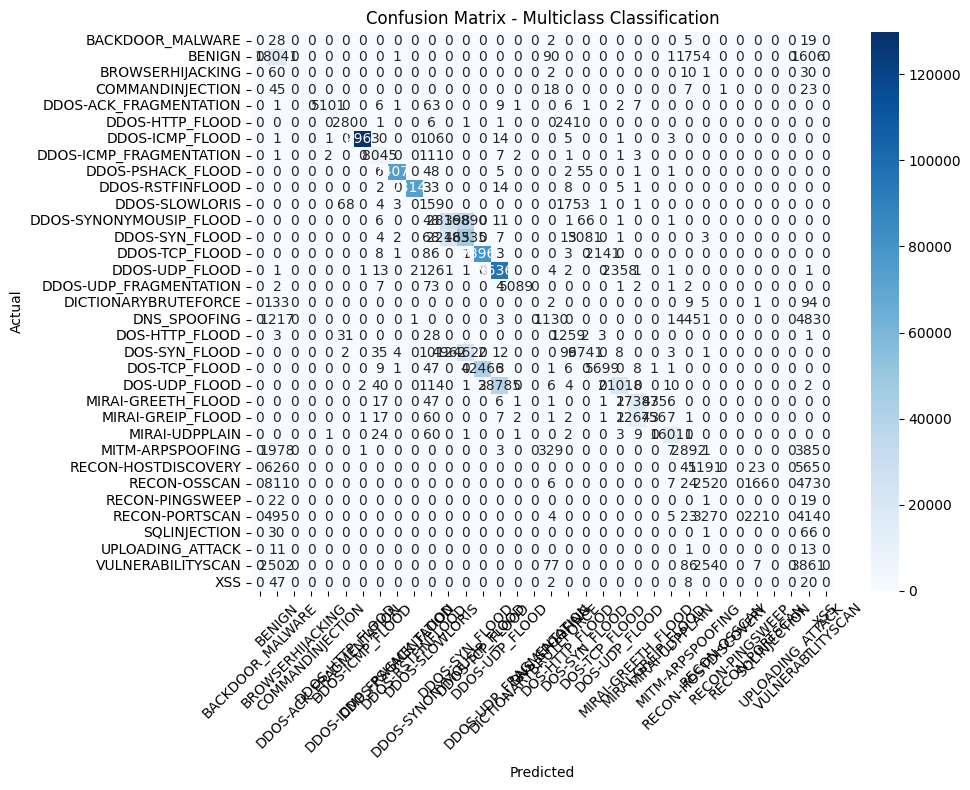

In [13]:
print("\n=== MULTICLASS CLASSIFICATION RESULTS ===")
test_loss_multi, test_acc_multi = model_multiclass.evaluate(X_test_multi, y_test_multi, verbose=0)
print(f"Test Accuracy: {test_acc_multi:.4f}")
print(f"Test Loss: {test_loss_multi:.4f}")

# Dự đoán
y_pred_multi = model_multiclass.predict(X_test_multi, verbose=0)
y_pred_multi_classes = np.argmax(y_pred_multi, axis=1)

print("\nClassification Report:")
print(metrics.classification_report(y_test_multi, y_pred_multi_classes,
                                    target_names=label_encoder.classes_))

print("\nConfusion Matrix:")
cm = metrics.confusion_matrix(y_test_multi, y_pred_multi_classes)
print(cm)

# Vẽ confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Multiclass Classification')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



#### **7. So sánh kết quả**


In [23]:
print("\n=== SUMMARY COMPARISON ===")
print(f"Binary Classification Accuracy: {test_acc:.4f}")
print(f"Multiclass Classification Accuracy: {test_acc_multi:.4f}")


=== SUMMARY COMPARISON ===
Binary Classification Accuracy: 1.0000
Multiclass Classification Accuracy: 0.7557
